In [1]:
# http

#### CBOE CNDR Replica
```
Below is an attempt to replicate the CBOE's CNDR index
based on the implementation described in their white paper.

http://www.cboe.com/index/dashboard/cndr#cndr-overview
https://www.cboe.com/publish/micropdf/CBOE-SP500-Iron-Condor-CNDR-Methodology-Paper.pdf

deviations:

+ option prices are replaced with estimated price using BSM.
+ roll date is every first business day, assuming next set of contracts expire on the first business day next month.
+ .2 and .05 delta not used instead using 0.7sd and 2sd otm call and puts.
+ no slippage models.
```

In [2]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
from py_vollib.ref_python.black_scholes_merton import black_scholes_merton

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import datetime as dt
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
start_date = '1980-1-1'
future_date = datetime.datetime.now().date()+datetime.timedelta(days=45)
end_date = future_date.strftime('%Y-%m-%d')
print(start_date,end_date)

1980-1-1 2021-01-11


In [4]:
def get_business_day(date):
    while date.isoweekday() > 5 or date in cal.holidays():
        date += dt.timedelta(days=1)
    return date

first_bday_of_month = [get_business_day(d).date() for d in pd.date_range(start_date, end_date, freq='BMS')]

In [5]:
# download and read CNDR index from CBOE website
cndr = pd.read_csv('static/CNDR_Data.csv')
cndr.index=[datetime.datetime.strptime(x,'%m/%d/%Y').date() for x in cndr.time]
cndr=cndr.drop(columns=['time','volume','open','high','low'])
cndr=cndr.rename(columns={'close':'cndr'})

In [6]:
cndr.head()

,cndr
1986-06-20,100.0
1986-06-23,100.0
1986-06-24,100.0
1986-06-25,100.0
1986-06-26,100.0


In [7]:
# get historical daily price for SPY
symbol = '^VIX'
tick = yf.Ticker(symbol)
vix_history = tick.history(period="max")
vix_history = vix_history.drop(
    columns=['Open','High','Low','Volume','Dividends','Stock Splits']
)
vix_history = vix_history.rename(columns={'Close':'implied_vol'})

symbol = '^IRX'# 13 Week Treasury Bill
tick = yf.Ticker(symbol)
tbill_history = tick.history(period="max")
tbill_history = tbill_history.drop(
    columns=['Open','High','Low','Volume','Dividends','Stock Splits']
)
tbill_history = tbill_history.rename(columns={'Close':'deannualized_interest_rate'})
tbill_history = tbill_history*0.01/365

symbol = 'SPY'
tick = yf.Ticker(symbol)
ticker_history = tick.history(period="max")
df = pd.merge(
    ticker_history,vix_history,
    how='left',left_index=True,right_index=True)
df = pd.merge(
    df,tbill_history,
    how='left',left_index=True,right_index=True)

df['close']=df.Close
df['open']=df.Open
df=df.drop(columns=['Open','High','Low','Close','Volume','Dividends','Stock Splits'])
df['ret']= np.log(df.close).diff(1)
df['realized_vol'] = df.ret.rolling(21).std()*np.sqrt(252)*100

df['ret21d']= df.close.pct_change(21)
df['ret21d_sd'] = df.ret21d.rolling(21).std()
df['ret21d_mean'] = df.ret21d.rolling(21).mean()

df = df.dropna()

# add in placeholders
df['expiry_date']=''
df['p1sd_strike']=np.nan
df['m1sd_strike']=np.nan
df['p2sd_strike']=np.nan
df['m2sd_strike']=np.nan
df['cost']=np.nan
df['cash']=np.nan
df['r']=np.nan

In [8]:
df.head()

,implied_vol,deannualized_interest_rate,close,open,ret,realized_vol,ret21d,ret21d_sd,ret21d_mean,expiry_date,p1sd_strike,m1sd_strike,p2sd_strike,m2sd_strike,cost,cash,r
Date,,,,,,,,,,,,,,,,,
1993-03-30,12.23,0.000080,26.966932,26.929659,0.002769,11.737076,0.025995,0.011409,0.021879,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-03-31,12.53,0.000079,26.948282,27.041464,-0.000692,10.671005,0.010313,0.011681,0.021286,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-04-01,13.02,0.000079,26.855091,26.985546,-0.003464,10.667118,0.002635,0.012370,0.020470,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-04-02,14.50,0.000080,26.296005,26.631461,-0.021038,12.834246,-0.012769,0.014255,0.019291,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-04-05,14.12,0.000079,26.426460,26.501006,0.004949,12.948246,-0.005099,0.014544,0.019115,,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
def compute_cost(row,open=False):
    
    today = row.index[-1].date()
    expiry_date = row.expiry_date.values[-1]
    
    p1sd_strike=row.p1sd_strike.values[-1]
    m1sd_strike=row.m1sd_strike.values[-1]
    p2sd_strike=row.p2sd_strike.values[-1]
    m2sd_strike=row.m2sd_strike.values[-1]
    
    sigma = row.implied_vol.values[-1]/100
    if open:
        underlying_price = row.open.values[-1]
    else:
        underlying_price = row.close.values[-1]
    
    dte = (expiry_date-today).days
    time_to_expiry_years = dte/365

    S = underlying_price
    K = p1sd_strike
    q = 0
    t = time_to_expiry_years
    r = 0
    sigma = sigma
    call_1sd_price = black_scholes_merton('c', S, K, t, r, sigma, q)

    S = underlying_price
    K = m1sd_strike
    q = 0
    t = time_to_expiry_years
    r = 0
    sigma = sigma
    put_1sd_price = black_scholes_merton('p', S, K, t, r, sigma, q)

    S = underlying_price
    K = p2sd_strike
    q = 0
    t = time_to_expiry_years
    r = 0
    sigma = sigma
    call_2sd_price = black_scholes_merton('c', S, K, t, r, sigma, q)

    S = underlying_price
    K = m2sd_strike
    q = 0
    t = time_to_expiry_years
    r = 0
    sigma = sigma
    put_2sd_price = black_scholes_merton('p', S, K, t, r, sigma, q)

    #call_1sd_price,put_1sd_price,call_2sd_price,put_2sd_price
    cost = put_2sd_price+call_2sd_price-put_1sd_price-call_1sd_price
    max_loss = np.max([p2sd_strike-p1sd_strike,m1sd_strike-m2sd_strike])
    
    return cost,max_loss

def myfunc(ser):
    # mark date to be roll date.
    # also set the strikes to purchase to setup iron condor.
    rows = df.loc[ser.index]
    row = rows.iloc[-1:]
    
    today = row.index[-1].date()
    index = row.index[-1]
    
    roll = False
    # first trade or roll day
    expiry_date = row.expiry_date.values[-1]
    if expiry_date == '' or today in first_bday_of_month:
        roll = True
    
    r1,r2=1,1
    
    if roll is False:
        
        # get info from yesterday
        yesterday_index = ser.index[-2]
        yesterday_cost = df.at[yesterday_index,'cost']
        yesterday_cash = df.at[yesterday_index,'cash']
        interest_rate = df.at[yesterday_index,'deannualized_interest_rate']
        
        # compute today's info
        cash = yesterday_cash*(1+interest_rate)
        cost, max_loss = compute_cost(row,open=False)
        
        df.at[index,'cost']=cost
        df.at[index,'cash']=cash
        
        r1=(yesterday_cash+yesterday_cost)/(cash+cost)
        
    if roll:
        
        contract_dates = np.array(first_bday_of_month)
        new_contract_index = np.argmin(np.abs([x.days for x in contract_dates-today]))
        expiry_date = contract_dates[new_contract_index+1]
        
        dte = (expiry_date-today).days
        ret_mean = row.ret21d_mean.values[-1]
        ret_sd = row.ret21d_sd.values[-1]        

        # http://www.cboe.com/index/dashboard/cndr
        underlying_price = row.close.values[-1]
        p1sd_strike = underlying_price*(1+ret_mean+0.7*ret_sd)
        m1sd_strike = underlying_price*(1+ret_mean+0.7*ret_sd)
        p2sd_strike = underlying_price*(1+ret_mean-2*ret_sd)
        m2sd_strike = underlying_price*(1+ret_mean-2*ret_sd)

        df.at[index,'expiry_date']=expiry_date
        df.at[index,'p1sd_strike']=p1sd_strike
        df.at[index,'m1sd_strike']=m1sd_strike
        df.at[index,'p2sd_strike']=p2sd_strike
        df.at[index,'m2sd_strike']=m2sd_strike
        
        row.expiry_date=expiry_date
        row.p1sd_strike=p1sd_strike
        row.m1sd_strike=m1sd_strike
        row.p2sd_strike=p2sd_strike
        row.m2sd_strike=m2sd_strike
        
        open_cost, open_max_loss = compute_cost(row,open=True)
        cash = open_max_loss*10
        cost, max_loss = compute_cost(row,open=False)
        
        r2 = (cash+cost)/(cash+open_cost)
        
        df.at[index,'cost']=cost
        df.at[index,'cash']=cash
        #print('roll')
    
    df.at[index,'r']=1-r1*r2
    #print(r1,r2)
    return 0 # must return value

#df = df.iloc[-100:,:]
df = df.iloc[-252*5:,:].copy()
rol = df.close.rolling(window=2)
_=rol.apply(myfunc, raw=False)
df = df.dropna()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
df.head()

,implied_vol,deannualized_interest_rate,close,open,ret,realized_vol,ret21d,ret21d_sd,ret21d_mean,expiry_date,p1sd_strike,m1sd_strike,p2sd_strike,m2sd_strike,cost,cash,r
Date,,,,,,,,,,,,,,,,,
2015-11-13,20.08,0.000003,183.584976,185.225596,-0.011292,12.339426,0.000939,0.027673,0.055584,2015-12-01,197.345634,197.345634,183.628887,183.628887,-7.603981,137.167467,0.011989
2015-11-16,18.16,0.000003,186.376755,183.385601,0.015093,13.325986,0.011561,0.028449,0.055039,2015-12-01,200.346260,200.346260,186.030397,186.030397,-8.626589,143.158635,-0.019257
2015-11-17,18.84,0.000004,186.240799,186.712138,-0.000730,13.333344,0.010326,0.029943,0.053601,2016-01-04,200.127128,200.127128,185.070311,185.070311,-5.710521,150.568177,0.002589
2015-11-18,16.85,0.000003,189.195709,186.757454,0.015742,14.316346,0.027670,0.030176,0.053307,2016-01-04,203.277580,203.277580,187.862705,187.862705,-6.290866,154.148750,-0.013791
2015-11-19,16.99,0.000002,189.032562,189.068813,-0.000863,14.079923,0.033193,0.030382,0.052938,2016-01-04,203.059690,203.059690,187.553205,187.553205,-6.252136,155.064854,0.000214


In [11]:
mdf = pd.merge(df,cndr,how='left',left_index=True,right_index=True)

In [12]:
mdf.head()

,implied_vol,deannualized_interest_rate,close,open,ret,realized_vol,ret21d,ret21d_sd,ret21d_mean,expiry_date,p1sd_strike,m1sd_strike,p2sd_strike,m2sd_strike,cost,cash,r,cndr
Date,,,,,,,,,,,,,,,,,,
2015-11-13,20.08,0.000003,183.584976,185.225596,-0.011292,12.339426,0.000939,0.027673,0.055584,2015-12-01,197.345634,197.345634,183.628887,183.628887,-7.603981,137.167467,0.011989,746.88
2015-11-16,18.16,0.000003,186.376755,183.385601,0.015093,13.325986,0.011561,0.028449,0.055039,2015-12-01,200.346260,200.346260,186.030397,186.030397,-8.626589,143.158635,-0.019257,747.27
2015-11-17,18.84,0.000004,186.240799,186.712138,-0.000730,13.333344,0.010326,0.029943,0.053601,2016-01-04,200.127128,200.127128,185.070311,185.070311,-5.710521,150.568177,0.002589,747.73
2015-11-18,16.85,0.000003,189.195709,186.757454,0.015742,14.316346,0.027670,0.030176,0.053307,2016-01-04,203.277580,203.277580,187.862705,187.862705,-6.290866,154.148750,-0.013791,743.77
2015-11-19,16.99,0.000002,189.032562,189.068813,-0.000863,14.079923,0.033193,0.030382,0.052938,2016-01-04,203.059690,203.059690,187.553205,187.553205,-6.252136,155.064854,0.000214,745.20


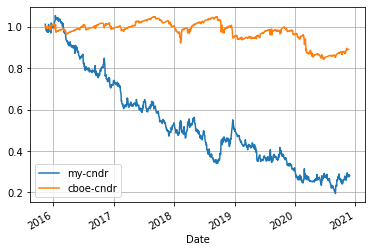

In [13]:
(1+np.cumsum(mdf.r)).plot(label='my-cndr')
(mdf.cndr/mdf.cndr.iloc[0]).plot(label='cboe-cndr')
plt.legend()
plt.grid(True)